In [1]:
%reload_ext autoreload
%autoreload 2

In [16]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from nlp_dauphine.preprocess_texts import (
    load_data,
    text_cleaning,
    link_texts_series,
    suppr_footnotes,
    categorical_other,
    find_language,
)
from nlp_dauphine.embeddings import (
    vocabulary,
    print_neighbors,
    sentence_representations,
)
from nlp_dauphine.preprocess_time_series import compute_rolling
from nlp_dauphine.utils import set_working_dir, cosine, euclidean
from category_encoders import WOEEncoder
from deep_translator import GoogleTranslator
from sklearn.model_selection import train_test_split
#from sklearn.decomposition import TruncatedSVD
#from sklearn.linear_model import LogisticRegression
#from sklearn.model_selection import cross_val_score

In [3]:
set_working_dir()

Current working dir: c:/Users/Hugo/Documents/Travail/A5/Dauphine_challenge/nlp_dauphine/notebooks
New working dir: c:/Users/Hugo/Documents/Travail/A5/Dauphine_challenge/nlp_dauphine


# Load Data

In [19]:
path = Path("data")
files_path = {
    "ecb": Path(path,"ecb_data.csv"),
    "fed": Path(path,"fed_data.csv"),
    "train_series": Path(path,"train_series.csv"),
}

In [20]:
# LOAD TEXT DATA
df_ecb, df_fed, df_train_series = load_data(files_path)
print(df_ecb.shape, df_fed.shape, df_train_series.shape)

(1772, 3) (739, 3) (8946, 14)


# Text Cleaning

## Link Texts to Series

Create some indices

In [6]:
df_ecb.reset_index(inplace=True, names="id_ecb")
df_fed.reset_index(inplace=True, names="id_fed")
df_train_series.reset_index(inplace=True, names="id_series")

Create a list rather than a string with a comma separator

In [7]:
df_train_series["id_ecb"] = [x.split(",") for x in df_train_series['index ecb']]
df_train_series["id_fed"] = [x.split(",") for x in df_train_series['index fed']]
del df_train_series['index ecb']
del df_train_series['index fed']

## Remove Footnotes

In [8]:
df_ecb["text_process"] = df_ecb.text.apply(lambda x: suppr_footnotes(x))
df_fed["text_process"] = df_fed.text.apply(lambda x: suppr_footnotes(x))

## Deal with Null Values

REPLACE NULL TEXTS BY TITLE

In [9]:
index_no_texts_ecb = df_ecb[df_ecb["text_process"].isnull()].index.values
df_ecb.loc[index_no_texts_ecb, "text_process"] = df_ecb.loc[index_no_texts_ecb, "title"].values

In [10]:
index_no_texts_fed = [
    i
    for i in range(len(df_fed.text_process))
    if (df_fed.text_process[i] == "         ")
    or (df_fed.text_process[i] == "        ")
    or (df_fed.text_process[i] == " ")
    or ()
]
df_fed.loc[index_no_texts_fed, "text_process"] = df_fed.loc[
    index_no_texts_fed, "title"
].values


## Translate Texts

In [12]:
df_ecb["lang"] = find_language(df_ecb.text_process) 
df_fed["lang"] = ["en" for _ in df_fed.text_process]
print(df_ecb.lang.value_counts())
print(df_fed.lang.value_counts())

en    1678
de      63
es      16
fr      12
it       3
Name: lang, dtype: int64
en    739
Name: lang, dtype: int64


We create a column to store which languages the speech was spoken (only for ECB as FED are all english)


We tranlate into english to simplify our pipeline (small volumne too)

Constaint of the API: The texts are cut to 5000 char

In [13]:
df_ecb.text_process = df_ecb.apply(
    lambda row: GoogleTranslator(source=row.lang, target="en").translate(
        text=row.text_process[:4999]
    )
    if row.lang != "en"
    else row.text_process,
    axis=1,
)


In [26]:
df_ecb.loc[df_ecb.lang != "en"].head()

,id_ecb,title,speaker,text,text_process,lang
31,31,Die Finanzmarktunion als Element einer stabile...,Jörg Asmussen,Die Finanzmarktunion als Element einer stabi...,The Financial Markets Union as an Element of a...,de
40,40,"Die EZB, das Geld und die Wirtschaft: Von A wi...",Sabine Lautenschläger,NaN,"The ECB, money and the economy: from A for rec...",de
48,48,SEPA in der Praxis - Sicht der Europäischen Ze...,Gertrude Tumpel-Gugerell,SEPA in der Praxis – Sicht der Europäischen ...,SEPA in Practice – Perspective of the European...,de
66,66,Auf dem Weg zum Euro - allegro ma non troppo,Jörg Asmussen,Auf dem Weg zum Euro – allegro ma non troppo...,On the way to the euro – allegro ma non troppo...,de
138,138,Discours délivré à l'occasion de la réception ...,Jean-Claude Trichet,Discours délivré à l'occasion de la réceptio...,Speech delivered on the occasion of the recept...,fr


In [13]:
df_ecb.to_csv("./data/ecb_data_translate.csv")
df_fed.to_csv("./data/fed_data_translate.csv")

## Remove special characters, stop words, Lemmatization...

In [14]:
# Clean Data
negation_words = ["no", "not", "never", "none", "nobody", "negative","nonetheless"]
df_fed.text_process = [text_cleaning(
        x,
        negation_set=negation_words,
        fg_no_numbers=True,
        fg_stop_words=True,
        fg_lemmatization=True,
    ) for x in df_fed.text_process]
df_ecb.text_process = [text_cleaning(
        x,
        negation_set=negation_words,
        fg_no_numbers=True,
        fg_stop_words=True,
        fg_lemmatization=True,
    ) for x in df_ecb.text_process]

In [15]:
df_ecb.to_csv("./data/ecb_data_translate_cleaned.csv")
df_fed.to_csv("./data/fed_data_translate_cleaned.csv")

Length of the texts

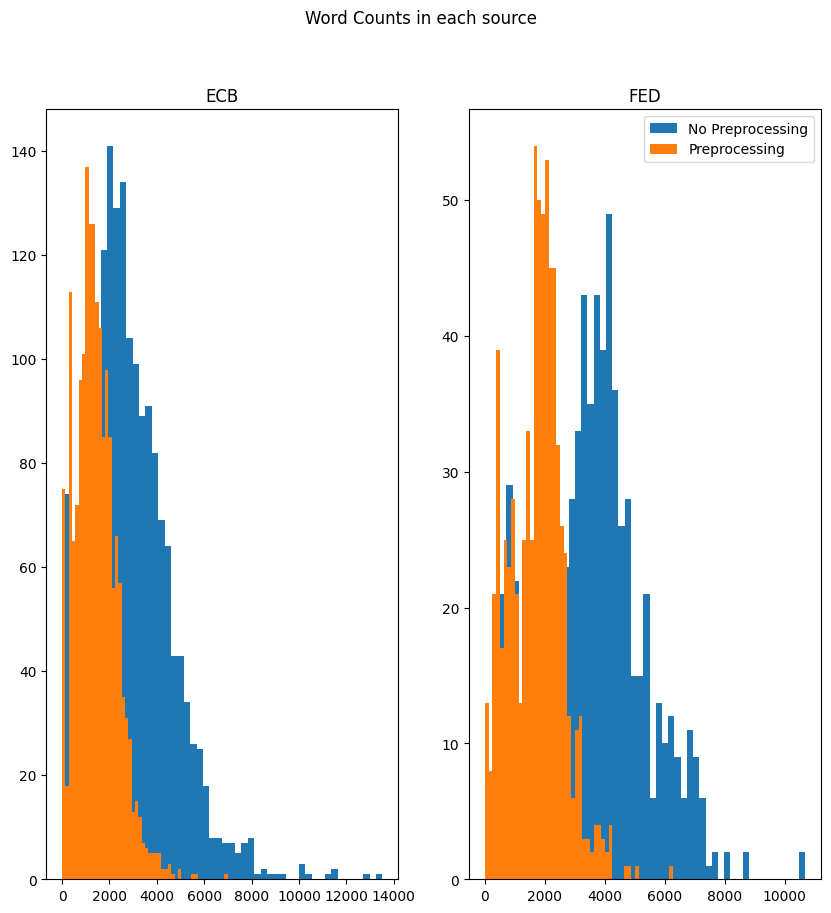

In [74]:
lenght_texts_ecb = [len(str(x).split(" ")) for x in df_ecb.text]
lenght_texts_fed = [len(str(x).split(" ")) for x in df_fed.text]
lenght_texts_ecb_process = [len(str(x).split(" ")) for x in df_ecb.text_process]
lenght_texts_fed_process = [len(str(x).split(" ")) for x in df_fed.text_process]
fig, ax = plt.subplots(1,2,figsize=(10,10))
ax[0].hist(lenght_texts_ecb, bins=50,label="No Preprocessing")
ax[0].hist(lenght_texts_ecb_process, bins=50,label="Preprocessing")
ax[0].set_title("ECB")
ax[1].hist(lenght_texts_fed, bins=50,label="No Preprocessing")
ax[1].hist(lenght_texts_fed_process, bins=50,label="Preprocessing")
ax[1].set_title("FED")
fig.suptitle("Word Counts in each source")
plt.legend(loc="upper right")
plt.show()

# Text Truncature

No more than `threshold` words

Still some doubts about it

In [15]:
threshold = 4000
df_ecb.text_process  = [" ".join(x.split(" ")[:threshold]) if len(str(x).split(" "))>=4000 else x for x in  df_ecb.text_process ]
df_fed.text_process = [" ".join(x.split(" ")[:threshold]) if len(str(x).split(" "))>=4000 else x for x in  df_fed.text_process ]


In [66]:
"""threshold = 4000
df_ecb.text_process = [" ".join(txt.split(" ")[:threshold]) for txt in df_ecb.text_process]
df_fed.text_process = [" ".join(txt.split(" ")[:threshold]) for txt in df_fed.text_process]"""

# Categorical Variable: Speakers

In [25]:
df_ecb.speaker = categorical_other(df_ecb.speaker)
df_fed.speaker = categorical_other(df_fed.speaker, threshold=0.025)

# Text Concatenation


In [44]:
df_series_ecb_process = link_texts_series(df_train_series, df_ecb, "id_series", "id_ecb")
df_series_fed_process = link_texts_series(df_train_series, df_fed, "id_series", "id_fed")

In [46]:
df_train_series = df_train_series.merge(df_series_ecb_process,on='id_series',how='left')
df_train_series = df_train_series.merge(df_series_fed_process,on='id_series',how='left')
df_train_series.head()

,id_series,Index Name,Index - 9,Index - 8,Index - 7,Index - 6,Index - 5,Index - 4,Index - 3,Index - 2,...,Index - 0,Index + 1,id_ecb,id_fed,text_concat_ecb,list_speakers_ecb,list_languages_ecb,text_concat_fed,list_speakers_fed,list_languages_fed
0,0,V2X Index,0.001045,0.005841,0.003832,-0.027519,-0.103565,-0.045086,-0.011265,0.005164,...,0.015779,0.010597,"[1126, 1471]",[96],welcome address welcome remark philip r lane m...,"[Philip R. Lane, Luis de Guindos]","[en, en]",delighted helsinki important conference moneta...,[Vice Chairman Richard H. Clarida],[en]
1,1,MOVE Index,-0.021497,0.007891,-0.013175,-0.008436,0.000000,0.026303,0.000556,0.001455,...,0.000000,0.014492,[975],[568],monetary policy structural reform euro area sp...,[Mario Draghi],[en],watch live would like thank federal reserve ba...,[Vice Chairman Stanley Fischer],[en]
2,2,SPX Index,-0.001872,-0.008154,0.023588,0.004086,0.003493,0.003300,0.000885,-0.011304,...,0.000156,0.016263,"[78, 806]","[328, 695]",challenge opportunity reboot european financia...,"[Benoît Cœuré, Benoît Cœuré]","[en, en]",grateful national association business economi...,"[Vice Chairman Stanley Fischer, Governor Lael ...","[en, en]"
3,3,SPX Index,0.004980,-0.000864,0.001677,0.000000,0.006030,-0.001083,0.000419,0.001492,...,-0.002582,0.013581,"[560, 1405]",[118],create stability uncertain world speech peter ...,"[Peter Praet, Peter Praet]","[en, en]",thank invitation speak today begin take stock ...,[Governor Jerome H. Powell],[en]
4,4,EURUSD Curncy,0.000360,-0.001893,0.005579,-0.003056,-0.001171,-0.001623,-0.002350,-0.006444,...,-0.000365,0.005092,[404],[261],money private currency reflection libra speech...,[Yves Mersch],[en],year symposium topic challenge monetary policy...,[Chairman Jerome H. Powell],[en]


Fed Texts are always in english so we don't keep that redundant information

In [53]:
del df_train_series["list_languages_fed"]

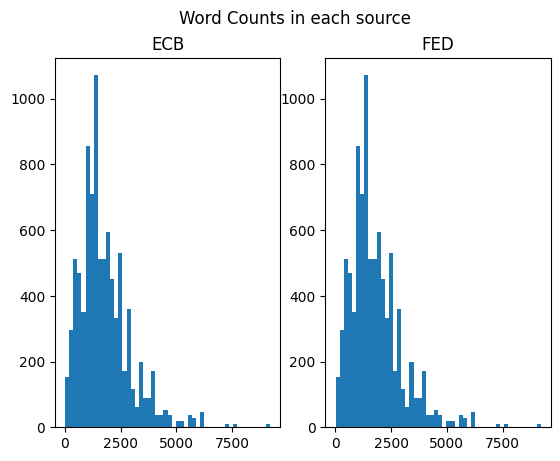

In [126]:
lenght_texts_ecb = [len(str(x).split(" ")) for x in df_train_series.text_concat_ecb]
lenght_texts_fed = [len(str(x).split(" ")) for x in df_train_series.text_concat_ecb]
fig, ax = plt.subplots(1,2)
ax[0].hist(lenght_texts_ecb, bins=50)
ax[0].set_title("ECB")
ax[1].hist(lenght_texts_fed, bins=50)
ax[1].set_title("FED")
fig.suptitle("Word Counts in each source")
plt.show()

# Removal Zero value Time series

Probably due to a score approximation 

Some times all indices are null

In [47]:
df_train_series.loc[df_train_series['Index + 1']==0.0]['Index Name'].value_counts()

SRVIX Index         428
CVIX Index           70
MOVE Index           50
VIX Index            41
V2X Index            36
SPX Index            36
SX5E Index           25
EURUSDV1M Curncy     13
EURUSD Curncy         7
Name: Index Name, dtype: int64

In [48]:
sup = df_train_series.loc[df_train_series['Index + 1']==0.0].index
df_train_series.drop(sup,inplace=True)

**Business rules**

If the entire series is full of zeros -> Output = 0

In [54]:
df_train_series.to_csv("./data/train_series_clean_no_0.csv")

# Loughran McDonald Test (not really useful for now)

No need for stemming/lemming

Upper case Necessary

In [110]:
df_ecb_mc, df_fed_mc, df_train_series_mc = load_data(files_path)
print(df_ecb_mc.shape, df_fed_mc.shape, df_train_series_mc.shape)

df_ecb_mc.reset_index(inplace=True, names="id_ecb")
df_fed_mc.reset_index(inplace=True, names="id_fed")
df_train_series_mc.reset_index(inplace=True, names="id_series")

df_train_series_mc["id_ecb"] = [x.split(",") for x in df_train_series_mc['index ecb']]
df_train_series_mc["id_fed"] = [x.split(",") for x in df_train_series_mc['index fed']]
del df_train_series_mc['index ecb']
del df_train_series_mc['index fed']

df_ecb_mc["text_process"] = df_ecb_mc.text.apply(lambda x: suppr_footnotes(x))
df_fed_mc["text_process"] = df_fed_mc.text.apply(lambda x: suppr_footnotes(x))

# REPLACE NULL TEXTS BY TITLE
index_no_texts_ecb = df_ecb_mc[df_ecb_mc["text_process"].isnull()].index.values
df_ecb_mc.loc[index_no_texts_ecb, "text_process"] = df_ecb_mc.loc[index_no_texts_ecb, "title"].values

index_no_texts_fed = [i for i in range(len(df_fed_mc.text_process)) if (df_fed_mc.text_process[i] == '         ') or (df_fed_mc.text_process[i] == '        ') or (df_fed_mc.text_process[i] == ' ') or ()]
df_fed_mc.loc[index_no_texts_fed, "text_process"] = df_fed_mc.loc[index_no_texts_fed, "title"].values

df_ecb_mc["lang"] = find_language(df_ecb_mc.text_process) 
df_fed_mc["lang"] = find_language(df_ecb_mc.text_process)
print(df_ecb_mc.lang.value_counts())
print(df_fed_mc.lang.value_counts())

df_ecb_mc.text_process = df_ecb_mc.apply(
    lambda row: GoogleTranslator(source=row.lang, target="en").translate(
        text=row.text_process[:4999]
    )
    if row.lang != "en"
    else row.text_process,
    axis=1,
)

# Clean Data
negation_words = ["no", "not", "never", "none", "nobody"]
df_fed_mc.text_process = [text_cleaning(
        x,
        negation_set=negation_words,
        fg_no_numbers=True,
        fg_stop_words=True,
        fg_lemmatization=False,
    ) for x in df_fed_mc.text_process]
df_ecb_mc.text_process = [text_cleaning(
        x,
        negation_set=negation_words,
        fg_no_numbers=True,
        fg_stop_words=True,
        fg_lemmatization=False,
    ) for x in df_ecb_mc.text_process]

threshold = 4000
df_ecb_mc.text_process = [" ".join(txt.split(" ")[:threshold]) for txt in df_ecb_mc.text_process]
df_fed_mc.text_process = [" ".join(txt.split(" ")[:threshold]) for txt in df_fed_mc.text_process]

df_ecb_mc

(1772, 3) (739, 3) (8946, 14)
en    1678
de      63
es      16
fr      12
it       3
Name: lang, dtype: int64
en    697
de     29
es      8
fr      5
Name: lang, dtype: int64


,id_ecb,title,speaker,text,text_process,lang
0,0,Comments by Yves Mersch at Financial Services ...,Yves Mersch,Comments by Yves Mersch at Financial Service...,comments yves mersch financial services summit...,en
1,1,Securing sustained economic growth in the euro...,Vítor Constâncio,Securing sustained economic growth in the eu...,securing sustained economic growth euro area s...,en
2,2,The role of monetary policy in addressing the ...,Mario Draghi,The role of monetary policy in addressing th...,role monetary policy addressing crisis euro ar...,en
3,3,The pandemic emergency: the three challenges f...,Philip R. Lane,SPEECH The pandemic emergency: the three c...,speech pandemic emergency three challenges ecb...,en
4,4,Transmission channels of monetary policy in th...,Peter Praet,Transmission channels of monetary policy in ...,transmission channels monetary policy current ...,en
...,...,...,...,...,...,...
1767,1767,"Navigating uncertainty - governance, risk mana...",Sabine Lautenschläger,"Navigating uncertainty – governance, risk ma...",navigating uncertainty governance risk managem...,en
1768,1768,3-6-3: Banks and change,Sabine Lautenschläger,3-6-3: Banks and change Speech by Sabine L...,3 banks change speech sabine lautenschläger me...,en
1769,1769,Europe's pursuit of ‘a more perfect Union',Mario Draghi,Europe’s pursuit of ‘a more perfect Union’ ...,europe pursuit perfect union lecture mario dra...,en
1770,1770,Monetary policy in the euro area - a brief ass...,Yves Mersch,Monetary policy in the euro area - a brief a...,monetary policy euro area brief assessment spe...,en


In [115]:
df_ecb_mc.text_process = [txt.upper() for txt in df_ecb_mc.text_process]
df_fed_mc.text_process = [txt.upper() for txt in df_fed_mc.text_process]

In [102]:
master_dictionary_file= "data\Loughran_McDonald_Dictionary.csv"
master_dictionary = {}
with open(master_dictionary_file) as csv_file:
    csv_reader = csv.DictReader(csv_file, delimiter=",")
    line_count = 0
    for row in csv_reader:
        master_dictionary[row["Word"]] = row
        line_count += 1
print(f"master dictionary has {len(master_dictionary)} words.")

master dictionary has 86531 words.


In [117]:
master_dictionary["EDUCATOR"]

{'Word': 'EDUCATOR',
 'Seq_num': '23795',
 'Word Count': '3418',
 'Word Proportion': '1.4966592569110276e-07',
 'Average Proportion': '1.3846473545104947e-07',
 'Std Dev': '7.033208155577571e-06',
 'Doc Count': '1639',
 'Negative': '0',
 'Positive': '0',
 'Uncertainty': '0',
 'Litigious': '0',
 'Strong_Modal': '0',
 'Weak_Modal': '0',
 'Constraining': '0',
 'Syllables': '4',
 'Source': '12of12inf'}

In [122]:
word2id_7500,id2word_7500 = vocabulary(df_ecb_mc.text_process,7500)

In [109]:
SENTIMENT_OUTPUT_FIELDS = {
    "Negative": 1,
    "Positive": 1,
    "Uncertainty": 1,
    "Litigious": 1,
    "Strong_Modal": 1,
    "Weak_Modal": 1,
    "Constraining": 1,
}

for txt in df_ecb_mc.text_process:
    txt_tokenize = txt.split(" ")
    total_tokens = 0
    for token in txt_tokenize:
        
        if (len(token) > 1
            and master_dictionary.get(token) is not None
            and token in word2id_7500.keys()):

            for key, item in SENTIMENT_OUTPUT_FIELDS.items():
                if (
                    master_dictionary[token][key] != "0"
                    and master_dictionary[token][key] != 0
                    and master_dictionary[token][key] != None
                ):
                    output_data[FIXED_OUTPUT_FIELDS.index(key)] += item

{'Word': 'THE',
 'Seq_num': '76950',
 'Word Count': '1586170835',
 'Word Proportion': '0.0694545717742845',
 'Average Proportion': '0.0698425525301629',
 'Std Dev': '0.011183918478162379',
 'Doc Count': '1140097',
 'Negative': '0',
 'Positive': '0',
 'Uncertainty': '0',
 'Litigious': '0',
 'Strong_Modal': '0',
 'Weak_Modal': '0',
 'Constraining': '0',
 'Syllables': '1',
 'Source': '12of12inf'}

# Train Test Split

In [131]:
df_ecb.loc[df_ecb.text_process.str.find("être")!=-1]

,id_ecb,title,speaker,text,text_process,lang
203,203,Swiss monetary policy as viewed by the Europea...,Jean-Claude Trichet,Swiss monetary policy as viewed by the Europ...,swiss monetary policy view european central ba...,en
279,279,Hearing at the Economic and Monetary Affairs C...,Jean-Claude Trichet,Hearing at the Economic and Monetary Affairs...,hear economic monetary affair committee europe...,en
415,415,Risk and monetary policy,Jean-Claude Trichet,Risk and monetary policy Lunch remarks by ...,risk monetary policy lunch remark jean claude ...,en
457,457,Remarks on the future of European financial re...,Jean-Claude Trichet,Remarks on the future of European financial ...,remark future european financial regulation su...,en
469,469,Having confidence in Europe,Benoît Cœuré,Having confidence in Europe Keynote speech...,confidence europe keynote speech benoît cœyou ...,en
552,552,Hearing at the Committee on Economic and Monet...,Jean-Claude Trichet,Hearing at the Committee on Economic and Mon...,hear committee economic monetary affair europe...,en
625,625,Remarks on the occasion of the European Banker...,Jean-Claude Trichet,Remarks on the occasion of the European Bank...,remark occasion european banker year award spe...,en
666,666,Europe - Cultural Identity - Cultural Diversity,Jean-Claude Trichet,Europe – Cultural Identity – Cultural Divers...,europe cultural identity cultural diversity sp...,en
735,735,Reviving the spirit of De Gasperi: working tog...,Mario Draghi,Reviving the spirit of De Gasperi: working t...,revive spirit de gasperi work together effecti...,en
775,775,The economic governance of the European Union ...,Lorenzo Bini Smaghi,The economic governance of the European Unio...,economic governance european union light treat...,en


In [124]:
##df_train_series.loc[df_train_series.text_concat_ecb.str.find("être")!=-1]
df_ecb.loc[df_ecb.text_process.str.find("être")!=-1].text_process.values[0]
b = df_ecb.loc[df_ecb.text.str.find("être")!=-1].text.values[1]
print(b)
a = re.search(r'\b(être)\b', b)
a.start()
b[900:]

nan


TypeError: expected string or bytes-like object

# Embeddings

## Build a vocabulary

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
corpus_ecb_train = X_train.text_concat_ecb.values
corpus_fed_train = X_train.text_concat_fed.values
vectorizer_ecb = TfidfVectorizer(max_features=4500)
vectorizer_fed = TfidfVectorizer(max_features=4500)
ecb_tfidf = vectorizer_ecb.fit_transform(corpus_ecb_train)
fed_tfidf = vectorizer_fed.fit_transform(corpus_fed_train)

In [114]:
df_ecb.loc[203].text_process

'swiss monetary policy view european central bank speech jean claude trichet president ecbon occasion th anniversary swiss national bank june zurich madame la présidente de la confédération suisse monsieur le président du gouvernement du liechtenstein minister excellency dear president bank council swiss national bank dear jean pierre roth dear chairman govern board swiss national bank dear fellow governor lady gentlemen immense pleasure today distinguish audience celebrate th anniversary foundation swiss national bank snb snb especially congratulate spite turbulence characterise period since two world war great depression great inflation succeed delivering average remarkably low inflation rate regard historical international perspective swiss price stability especially appropriate historical international perspective low inflation country note notwithstanding great inflation episode temporary inflationary outburst correspond two world war united state correctly characterise see long r

In [113]:
import re
b = X_train.text_concat_ecb[5030]
a = re.search(r'\b(être)\b', b)
print(b[25775:])
#df_train_series.loc[5030]

s être à zurich nous avions célébré le ième anniversaire de la banque de france il ans en rendant un vibrant hommage à un citoyen suisse la banque de france été créée par napoléon en sur une proposition du financier jean frédéric perregaux qui en été ensuite le responsable monsieur perregaux était l un de ce financier suisse à la fois très imaginatifs très sag et très prudents not la réputation est légendaire à travers les siècles anschließend möchte ich hervorheben wie vorbildlich die beziehungen sind die alle zentralbanken der welt mit der schweiz sowie der schweizerischen nationalbank unterhalten die offenheit der snb und ihre aktive beteiligung geldpolitischen fragestellungen und der geldpolitischen forschung auf europäischer und internationaler ebene werden sehr geschätzt jean pierre roth dem wir unsere regelmäßigen zusammenkünfte basel zu verdanken haben leistet al präsident de verwaltungsrats der bank für internationalen zahlungsausgleich hervorragende arbeit ihm möchte ich heut

In [93]:
X_train.loc[X_train.text_concat_ecb.str.find("être")!=-1]

,Index - 9,Index - 8,Index - 7,Index - 6,Index - 5,Index - 4,Index - 3,Index - 2,Index - 1,Index - 0,...,_SPX Index,_SRVIX Index,_SX5E Index,_V2X Index,_VIX Index,ecb__de,ecb__en,ecb__es,ecb__fr,ecb__it
5030,-0.007067,-0.077387,-0.103517,-0.036053,0.004396,0.042925,0.066375,0.000000,0.034775,-0.023048,...,0,0,0,0,0,0,2,0,0,0
3622,-0.002517,-0.001867,0.020420,-0.000676,-0.002440,0.006978,-0.002630,-0.009888,-0.013294,-0.012720,...,0,0,1,0,0,0,2,0,0,0
7286,0.001077,0.002917,-0.002456,0.005594,-0.001300,-0.001608,-0.000383,0.002068,0.000229,-0.010457,...,0,0,0,0,0,0,1,0,0,0
4009,0.023557,-0.031715,-0.003744,-0.024658,0.008567,-0.010015,0.000104,0.026624,-0.008006,0.012693,...,0,0,1,0,0,0,1,0,0,0
1041,-0.017858,0.013694,0.026353,0.007715,0.023338,0.005429,0.005622,0.034321,0.000000,0.000000,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7719,0.014417,-0.013821,0.012643,0.000785,-0.002553,0.007640,-0.008821,0.011550,0.036124,-0.008673,...,0,0,0,0,0,0,1,0,0,0
5038,-0.023053,-0.000533,0.015710,-0.007518,0.016233,0.026541,0.001484,-0.050369,0.007923,0.001738,...,1,0,0,0,0,0,2,1,0,0
7631,-0.013765,-0.009130,-0.006826,0.001077,0.002917,-0.002456,0.005594,-0.001300,-0.001608,-0.000383,...,0,0,0,0,0,0,1,0,0,0
6088,0.009760,-0.033494,0.019032,0.043594,0.154736,-0.046018,0.000000,0.131828,-0.066324,-0.043669,...,0,0,0,0,1,0,1,0,0,0


In [83]:
vectorizer_ecb.get_feature_names_out()
# Preprocessing to improve

array(['ab', 'abandon', 'ability', ..., 'zum', 'époque', 'être'],
      dtype=object)

In [139]:
from nlp_dauphine.model import FullModel
params_ecb = {
    "drop_prob": 0.4,
    "n_input": 4500,
    "n_hidden1": 2048,
    "n_hidden2": 1024,
    "n_hidden3": 512,
    "n_hidden4": 256,
    "n_hidden5": 128,
}
params_fed = {
    "drop_prob": 0.4,
    "n_input": 4500,
    "n_hidden1": 2048,
    "n_hidden2": 1024,
    "n_hidden3": 512,
    "n_hidden4": 256,
    "n_hidden5": 128,
}

params_full = {
    "ecb_params":params_ecb,
    "fed_params":params_fed,
    "n_input_series_meta":82,
    "n_hidden_tot_1":256,
    "n_hidden_tot_2":128,
    "n_hidden_tot_3":64,
    "drop_prob":0.4,
}

model = FullModel(**params_full)
model

FullModel(
  (relu): ReLU()
  (dropout): Dropout(p=0.4, inplace=False)
  (ecb_fc): BankNLP(
    (relu): ReLU()
    (dropout): Dropout(p=0.4, inplace=False)
    (fc1): Linear(in_features=4500, out_features=2048, bias=True)
    (fc2): Linear(in_features=2048, out_features=1024, bias=True)
    (fc3): Linear(in_features=1024, out_features=512, bias=True)
    (fc4): Linear(in_features=512, out_features=256, bias=True)
    (fc5): Linear(in_features=256, out_features=128, bias=True)
  )
  (fed_fc): BankNLP(
    (relu): ReLU()
    (dropout): Dropout(p=0.4, inplace=False)
    (fc1): Linear(in_features=4500, out_features=2048, bias=True)
    (fc2): Linear(in_features=2048, out_features=1024, bias=True)
    (fc3): Linear(in_features=1024, out_features=512, bias=True)
    (fc4): Linear(in_features=512, out_features=256, bias=True)
    (fc5): Linear(in_features=256, out_features=128, bias=True)
  )
  (fc_tot_1): Linear(in_features=338, out_features=256, bias=True)
  (fc_tot_2): Linear(in_features=2

In [140]:
import torch.optim as optim 
import torch.nn as nn
# Create an optimizer
opt = optim.Adam(model.parameters(), lr=0.0025, betas=(0.9, 0.999))
# The criterion is a binary cross entropy loss based on logits - meaning that the sigmoid is integrated into the criterion
criterion = nn.BCEWithLogitsLoss()

In [141]:
from nlp_dauphine.training import experiment
train_losses = experiment(model, opt, criterion,num_epochs=10)

TypeError: experiment() missing 3 required positional arguments: 'training_dataloader', 'valid_dataloader', and 'test_dataloader'

## PMI

Pointwise Mutual Information: The aim is to assess the extent to which the co-occurrence of the two terms is unexpected. This measure is the ratio of the joint probability of the two words and the product of their individual probabilities

In [147]:
word2id_7500["kapitalmarktkonferenz"]

5155

In [144]:
def pmi(co_oc, positive=True):
    sum_vec = co_oc.sum(axis=0)
    sum_tot = sum_vec.sum()
    with np.errstate(divide='ignore'):
        pmi = np.log((co_oc * sum_tot) / (np.outer(sum_vec, sum_vec)))                   
    pmi[np.isinf(pmi)] = 0.0  # log(0) = 0
    if positive:
        pmi[pmi < 0] = 0.0
    return pmi



PPMI20_ecb= pmi(M20dist_ecb)
PPMI20_fed = pmi(M20dist_fed)

### (handle nan values)
PPMI20_ecb = np.nan_to_num(PPMI20_ecb)
PPMI20_fed = np.nan_to_num(PPMI20_fed)
###

print("Avec la PPMI:")    
print_neighbors(euclidean, word2id_7500, PPMI20_ecb, 'financial')
print_neighbors(cosine, word2id_7500, PPMI20_ecb, 'financial')
print_neighbors(euclidean, word2id_7500, PPMI20_fed, 'financial')
print_neighbors(cosine, word2id_7500, PPMI20_fed, 'financial')



C:\Users\Hugo\AppData\Local\Temp\ipykernel_83376\1068795337.py:5: RuntimeWarning: invalid value encountered in divide
  pmi = np.log((co_oc * sum_tot) / (np.outer(sum_vec, sum_vec)))


Avec la PPMI:
Plus proches voisins de financial selon la distance 'euclidean': 
[['executive', 'dz', 'kapitalmarktkonferenz', 'board', 'seventeenth', 'member', 'ep', '20', 'reboot']]
Plus proches voisins de financial selon la distance 'cosine': 
[['system', 'crisis', 'stability', 'market', 'risk', 'global', 'institution', 'sector', 'contagion']]
Plus proches voisins de financial selon la distance 'euclidean': 
[['honourable', 'conseil', 'deliverable', 'unbundling', 'banknotes', 'underlines', 'climax', 'barcelona', 'abord']]


C:\Users\Hugo\Documents\Travail\A5\Dauphine_challenge\nlp_dauphine\src\nlp_dauphine\utils.py:23: RuntimeWarning: invalid value encountered in divide
  return u / np.sqrt(u.dot(u))


Plus proches voisins de financial selon la distance 'cosine': 
[['crisis', 'system', 'stability', 'institution', 'firm', 'risk', 'market', 'regulation', 'global']]


## Embeddings from the co-occurence Matrix


### PPMI (not good)

In [197]:
train_rep_ecb_ppmi = sentence_representations(txt_ecb, word2id_7500, PPMI20_ecb, np_func=np.sum)
train_rep_fed_ppmi = sentence_representations(txt_fed, word2id_7500, PPMI20_fed, np_func=np.sum)
val_rep_ecb_ppmi = sentence_representations(txt_ecb_val, word2id_7500, PPMI20_ecb, np_func=np.sum)
val_rep_fed_ppmi = sentence_representations(txt_fed_val, word2id_7500, PPMI20_fed, np_func=np.sum)

100%|██████████| 1648/1648 [02:55<00:00,  9.36it/s]
